In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/UFNO

Mounted at /content/drive
/content/drive/MyDrive/UFNO


In [ ]:
!nvidia-smi

Tue Nov  7 21:37:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    44W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
import time

device = torch.device("cuda:0")# if torch.cuda.is_available() else "cpu")

# !pip install torch_xla
#import torch_xla
#import torch_xla.core.xla_model as xm
#import torch_xla.distributed.parallel_loader as pl

import numpy as np
from ufno import *
from lploss import *

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
#train_input = torch.load('UVt_r-input-data.pt')
input_train = torch.load('input_train.pt')
output_train = torch.load('output_train.pt')

print(input_train.shape)
print(output_train.shape)


torch.Size([524, 97, 97, 3, 3])
torch.Size([524, 97, 97, 3])


In [ ]:
# normalizing the training input data
# normalize the release time first (divide all by 6 (max value))
input_train[:,:,:,:,2] = input_train[:,:,:,:,2]/6
input_train[:,:,:,:,2]

# normalize U and V to the range [0, 1]
min_value0 = input_train[:,:,:,:,0].min().item()
max_value0 = input_train[:,:,:,:,0].max().item()

min_value1 = input_train[:,:,:,:,1].min().item()
max_value1 = input_train[:,:,:,:,1].max().item()

input_train[:,:,:,:,0] = (input_train[:,:,:,:,0] - min_value0) / (max_value0 - min_value0)
input_train[:,:,:,:,1] = (input_train[:,:,:,:,1] - min_value1) / (max_value1 - min_value1)

In [ ]:
# normalizing the output data to 0 mean and unit std

mean_value = output_train[:,:,:,:].mean().item()
print ("mean_value =", mean_value)
std_value = output_train[:,:,:,:].std().item()
print ("std value =", std_value)
output_train[:,:,:,:] = (output_train[:,:,:,:] - mean_value) / std_value

mean_value = 1.990989489137778e-17
std value = 2.3570086714735916e-16


In [ ]:
mode1 = 10
mode2 = 10
mode3 = 4
width = 36
model = Net3d(mode1, mode2, mode3, width)

model.to(device)

Net3d(
  (conv1): SimpleBlock3d(
    (fc0): Linear(in_features=3, out_features=36, bias=True)
    (conv0): SpectralConv3d()
    (conv1): SpectralConv3d()
    (conv2): SpectralConv3d()
    (conv3): SpectralConv3d()
    (conv4): SpectralConv3d()
    (conv5): SpectralConv3d()
    (w0): Conv1d(36, 36, kernel_size=(1,), stride=(1,))
    (w1): Conv1d(36, 36, kernel_size=(1,), stride=(1,))
    (w2): Conv1d(36, 36, kernel_size=(1,), stride=(1,))
    (w3): Conv1d(36, 36, kernel_size=(1,), stride=(1,))
    (w4): Conv1d(36, 36, kernel_size=(1,), stride=(1,))
    (w5): Conv1d(36, 36, kernel_size=(1,), stride=(1,))
    (unet3): U_net(
      (conv1): Sequential(
        (0): Conv3d(36, 36, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
        (3): Dropout(p=0, inplace=False)
      )
      (conv2): Sequential(
        (0): Conv

In [ ]:
epochs = 140
e_start = 0
learning_rate = 0.001
scheduler_step = 4
scheduler_gamma = 0.85
learning_rate

0.001

In [ ]:
batch_size = 4

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(input_train, output_train), batch_size=batch_size, shuffle=True)


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)
myloss = LpLoss(size_average=False)


In [ ]:
train_l2 = 0.0
start_time = time.time()

for ep in range(1,epochs+1):
    model.train()
    train_l2 = 0
    counter = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        # reshape the output of the UFNO model to (-1,97,97,6)
        pred = model(x).view(-1,97,97,3)
        ori_loss = 0

        # original loss
        for i in range(batch_size):
            ori_loss += myloss(pred[i,...].reshape(1, -1), y[i,...].reshape(1, -1))
        loss = ori_loss
        loss.backward()
        optimizer.step()
        train_l2 += loss.item()

        counter += 1
        if counter % 100 == 0:
            print(f'epoch: {ep}, batch: {counter}/{len(train_loader)}, train loss: {loss.item()/batch_size:.4f}')

    scheduler.step()

    print(f'epoch: {ep}, train loss: {train_l2/input_train.shape[0]:.4f}')
    lr_ = optimizer.param_groups[0]['lr']

end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

epoch: 1, batch: 100/131, train loss: 49.7319
epoch: 1, train loss: 97.8333
epoch: 2, batch: 100/131, train loss: 71.9985
epoch: 2, train loss: 90.0170
epoch: 3, batch: 100/131, train loss: 44.0715
epoch: 3, train loss: 82.0650
epoch: 4, batch: 100/131, train loss: 74.0929
epoch: 4, train loss: 76.5773
epoch: 5, batch: 100/131, train loss: 94.7635
epoch: 5, train loss: 73.2611
epoch: 6, batch: 100/131, train loss: 35.2725
epoch: 6, train loss: 69.1600
epoch: 7, batch: 100/131, train loss: 84.9599
epoch: 7, train loss: 64.3031
epoch: 8, batch: 100/131, train loss: 66.1819
epoch: 8, train loss: 61.3368
epoch: 9, batch: 100/131, train loss: 101.6413
epoch: 9, train loss: 58.7368
epoch: 10, batch: 100/131, train loss: 96.8893
epoch: 10, train loss: 56.1466
epoch: 11, batch: 100/131, train loss: 48.9096
epoch: 11, train loss: 53.2374
epoch: 12, batch: 100/131, train loss: 30.0020
epoch: 12, train loss: 51.7103
epoch: 13, batch: 100/131, train loss: 25.3040
epoch: 13, train loss: 48.6949
epo

In [ ]:
torch.save(model, 'UFNO_predict_RMSE_lploss')

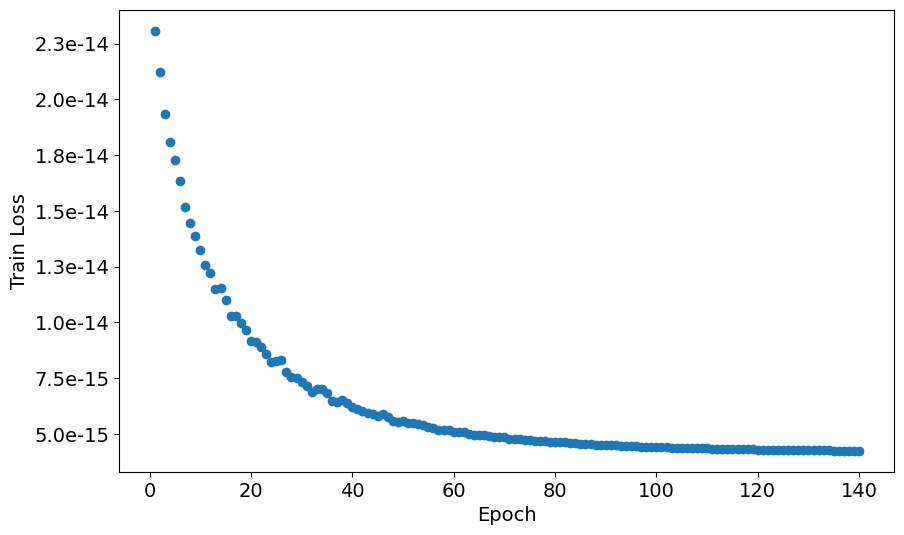

In [ ]:
# List of train loss values
train_loss_values =[
    97.8333, 90.0170, 82.0650, 76.5773, 73.2611, 69.1600, 64.3031, 61.3368, 58.7368,
    56.1466, 53.2374, 51.7103, 48.6949, 48.8621, 46.5818, 43.6388, 43.4601, 42.1905,
    40.9391, 38.7659, 38.5362, 37.6775, 36.3434, 34.7713, 34.9125, 35.2694, 32.9246,
    31.9476, 31.7418, 31.0709, 30.1762, 29.1574, 29.5652, 29.5927, 28.8303, 27.4606,
    27.1910, 27.4911, 27.0708, 26.2823, 25.8832, 25.4220, 25.0532, 24.9390, 24.6085,
    24.9817, 24.2975, 23.5893, 23.3198, 23.5627, 23.2266, 23.1324, 22.9760, 22.8224,
    22.4218, 22.1601, 21.9229, 21.7975, 21.7924, 21.5061, 21.4656, 21.4173, 21.1164,
    20.9190, 20.8673, 20.8990, 20.6714, 20.5143, 20.4565, 20.5516, 20.1927, 20.1177,
    20.0755, 20.0246, 19.9060, 19.7917, 19.6958, 19.6705, 19.6068, 19.5325, 19.4879,
    19.4849, 19.3705, 19.2952, 19.2431, 19.1952, 19.1408, 19.0828, 19.0386, 18.9990,
    18.9567, 18.9122, 18.8878, 18.8307, 18.7814, 18.7504, 18.7103, 18.6793, 18.6413,
    18.6097, 18.5830, 18.5638, 18.5176, 18.4906, 18.4664, 18.4377, 18.4038, 18.3809,
    18.3597, 18.3406, 18.3077, 18.2889, 18.2661, 18.2504, 18.2227, 18.2091, 18.1916,
    18.1751, 18.1508, 18.1374, 18.1243, 18.1092, 18.0900, 18.0779, 18.0670, 18.0522,
    18.0350, 18.0251, 18.0145, 18.0039, 17.9921, 17.9804, 17.9719, 17.9618, 17.9510,
    17.9438, 17.9352, 17.9281, 17.9188, 17.9118
]
# Convert the list to a NumPy array
train_loss_array = np.array(train_loss_values)

mean_value = 1.990989489137778e-17
std_value = 2.3570086714735916e-16

# convert to original scale
train_loss_array = train_loss_array* std_value + mean_value
# You now have the train loss values in a NumPy array
#print(train_loss_array)

x_values = np.arange(1, 141)

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(x_values, train_loss_array, marker='o', linestyle='None')
# Set the y-axis label format to display values in e-15
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1e}'))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.grid(False)

plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Train Loss', fontsize=14)

plt.show()